# Chess.com Data Analysis

## Install Packages

In [ ]:
!pip install pandas
# !pip install chess.com

In [2]:
# from chessdotcom import get_player_profile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from datetime import datetime
import json
from tqdm import tqdm

## Data Pre Processing

In [3]:
username = 'Spicy_Chris'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
pd.set_option('display.max_columns', None)

### Gather Data

In [4]:
stats_url = f"https://api.chess.com/pub/player/{username}/stats"
player_stats = requests.get(stats_url, headers=headers).json()

In [5]:
# Get all games since creation date and save to pd dataframe
all_games = []
todays_date = datetime.now()
monthly_data_urls = requests.get(f"https://api.chess.com/pub/player/{username}/games/archives", headers=headers).json()['archives']
for url in tqdm(monthly_data_urls, position=0, leave=True):
    games = requests.get(url, headers=headers).json()['games']        
    all_games += games
print(f"Found {len(all_games)} Games")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:31<00:00,  1.08it/s]

Found 6340 Games


In [6]:
# Build df
df = pd.DataFrame.from_dict(all_games, orient='columns')
df.head(1)

,url,pgn,time_control,end_time,rated,accuracies,tcn,uuid,initial_setup,fen,time_class,rules,white,black,tournament,start_time
0,https://www.chess.com/game/live/8717136503,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat...",600,1614978232,True,"{'white': 13.815347900907305, 'black': 49.7934...",gv0KmC5Qbs!TltZJcMJCtC9zMT7TfH8!eg2UpFQBsJBvov...,c5f9483e-7df5-11eb-bd8a-536974010001,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,2r2r2/pp4kp/2p3p1/1B2pp2/1b2P2Q/8/PPP2P2/R4RK1...,rapid,chess,"{'rating': 981, 'result': 'win', '@id': 'https...","{'rating': 792, 'result': 'resigned', '@id': '...",NaN,NaN


### Clean Data

In [7]:
# Remove non-traditional games (Fischer random, bughouse, chess960, ...)
df = df.query("rules == 'chess'")
df = df.rename(columns={"start_time": "start_time_utx", "end_time": "end_time_utx"})

In [8]:
# Pull the important information out of the pgn column and return it in a dict
def pgn_to_dict(pgn) -> dict:
    pgn_data = {}
    idx_to_col = {
        2: 'start_date',
        6: 'result',
        9: 'ECO',
        16: 'termination',
        17: 'start_time',
        18: 'end_date',
        19: 'end_time',
        22: 'moves'
    }
    
    for i, row in enumerate(pgn.split('\n')):
        if i in idx_to_col.keys():
            if i == 22:
                pgn_data[idx_to_col[i]] = row
            else:
                data = row.split("\"")[1]
                pgn_data[idx_to_col[i]] = data
    return pgn_data

In [9]:
# Turn the string of pgn moves into a json format
def game_notation_to_json(moves):
    moves_json = {}
    for i, line in enumerate(moves.split(']} ')):
        if i+1 == len(moves.split(']}')):
            break
            
        w_or_b = 'white' if i % 2 == 0 else 'black'
        move_no, move, clock = line.replace('{[%clk ', '').replace('..', '').replace('. ', ' ').split(' ')
        move_no = int(move_no)
        ply_data = {'move': move, 'clock': clock}
                
        if move_no not in moves_json.keys():
            moves_json[move_no] = { 'white': {'move': None, 'clock': None},
                                    'black': {'move': None, 'clock': None}, }
                
        moves_json[move_no][w_or_b] = ply_data
    return moves_json

In [10]:
from bs4 import BeautifulSoup 
import html5lib

# Web scrape openings and their eco codes
eco_codes = {}
eco_url = "https://www.chessgames.com/chessecohelp.html"
eco_response = requests.get(eco_url, headers=headers)

soup = BeautifulSoup(eco_response.content, "html.parser")
for row in soup.find_all('tr'):
    eco = row.find_all('td')[0].get_text()
    opening_data = row.find_all('td')[1].get_text().split('\n')
    eco_codes[eco] = opening_data

In [12]:
# Expand all nested data data on one row
for index, row in tqdm(df.iterrows(), position=0, leave=True):
    # Expand accuracies column
    w_accuracy = None
    b_accuracy = None
    
    # If the game was analyzed, add accuracies
    if type(row['accuracies']) != float:
        w_accuracy = row['accuracies']['white']
        b_accuracy = row['accuracies']['black']
    
    # Expand white column
    df.at[index, 'w_accuracy'] = w_accuracy
    df.at[index, 'w_rating'] = row['white']['rating']
    df.at[index, 'w_result'] = row['white']['result']
    df.at[index, 'w_username'] = row['white']['username']
    
    # Expand black column
    df.at[index, 'b_accuracy'] = b_accuracy
    df.at[index, 'b_rating'] = row['black']['rating']
    df.at[index, 'b_result'] = row['black']['result']
    df.at[index, 'b_username'] = row['black']['username']
    
    # Expand pgn column
    pgn_data = pgn_to_dict(row['pgn'])
    for col_name, pgn_row in pgn_data.items():
        df.at[index, col_name] = pgn_row
    
    # Expand moves column
    moves_json = game_notation_to_json(pgn_data['moves'])
    
    # rating = game['w_rating'] if game['w_username'] == username else game['b_rating']
    # Check the game has move history
    if len(moves_json) > 0:
        df.at[index, 'moves'] = moves_json
        df.at[index, 'opening'] = eco_codes[df.at[index, 'ECO']][0]
        df.at[index, 'opening_moves'] = eco_codes[df.at[index, 'ECO']][1]
        ply = (len(moves_json) * 2 - 1) if moves_json[len(moves_json)]['black']['move'] == None else (len(moves_json) * 2)
        df.at[index, 'ply'] = int(ply)


6335it [00:05, 1215.52it/s]


In [13]:
# Remove old / unwanted columns
df = df.drop(columns=['accuracies', 'black', 'white', 'pgn', 'initial_setup'], axis=1)

# Order by date
df.sort_values('end_time_utx')

,url,time_control,end_time_utx,rated,tcn,uuid,fen,time_class,rules,tournament,start_time_utx,w_accuracy,w_rating,w_result,w_username,b_accuracy,b_rating,b_result,b_username,start_date,result,ECO,termination,start_time,end_date,end_time,moves,opening,opening_moves,ply
0,https://www.chess.com/game/live/8717136503,600,1614978232,True,gv0KmC5Qbs!TltZJcMJCtC9zMT7TfH8!eg2UpFQBsJBvov...,c5f9483e-7df5-11eb-bd8a-536974010001,2r2r2/pp4kp/2p3p1/1B2pp2/1b2P2Q/8/PPP2P2/R4RK1...,rapid,chess,NaN,NaN,13.815348,981.0,win,Spicy_Chris,49.793494,792.0,resigned,rigbl,2021.03.05,1-0,C40,Spicy_Chris won by resignation,21:00:09,2021.03.05,21:03:52,"{1: {'white': {'move': 'Nf3', 'clock': '0:10:0...",King's Knight Opening,1 e4 e5 2 Nf3,40.0
1,https://www.chess.com/game/live/8717206583,600,1614978702,True,mC5Qbs0KfH9Igv2MvM7MltMohfInfnonenZRsJ45ne3NkA...,4d83ec20-7df6-11eb-bd8a-536974010001,3Q4/2p2p2/p1ppk3/4p1rp/2P1P1b1/3P4/PP5P/R3K3 w...,rapid,chess,NaN,NaN,NaN,1015.0,win,Shelykoopa,NaN,865.0,resigned,Spicy_Chris,2021.03.05,1-0,C25,Shelykoopa won by resignation,21:03:58,2021.03.05,21:11:42,"{1: {'white': {'move': 'e4', 'clock': '0:09:58...",Vienna,1 e4 e5 2 Nc3,42.0
2,https://www.chess.com/game/live/8717765217,600,1614979745,True,gvZJbs!Tmu0SfHYQHt9ziqzsls8!vK5ZnDQItHWOHZ6Zeg...,63aeb534-7df7-11eb-bd8a-536974010001,1Q4k1/8/p3p1K1/1P1pPrp1/8/2P1P3/2P5/R1B4r b - -,rapid,chess,NaN,NaN,30.849567,956.0,win,Spicy_Chris,38.304636,817.0,timeout,josiefa,2021.03.05,1-0,A06,Spicy_Chris won on time,21:11:41,2021.03.05,21:29:05,"{1: {'white': {'move': 'Nf3', 'clock': '0:10:0...",Reti Opening,1 Nf3 d5,75.0
3,https://www.chess.com/game/live/8932634011,300,1615194322,True,mC5QgvZJCJ7JbsJSfmXPvMSLlB0KmA6SBJ3VMvKCvFLEJS...,3a105422-7fec-11eb-968e-536974010001,4Q3/pkp1R3/1pn3rB/8/8/1P6/P1P2PqP/5RK1 w - -,blitz,chess,NaN,NaN,34.754114,767.0,checkmated,liptondavid,14.971387,965.0,win,Spicy_Chris,2021.03.08,0-1,B00,Spicy_Chris won by checkmate,08:56:53,2021.03.08,09:05:22,"{1: {'white': {'move': 'e4', 'clock': '0:05:00...",Uncommon King's Pawn Opening,1 e4,56.0
4,https://www.chess.com/game/live/8933228327,600,1615194896,True,gvYImuZJks2UfH6ZdyWOvK!THZTZKZ5ZlBIAjzXHyGZPnv...,886020b1-7fed-11eb-968e-536974010001,4kR1r/r3p2p/p5p1/4q1B1/1Pp1p3/2n5/P5PP/R3K3 b ...,rapid,chess,NaN,NaN,NaN,864.0,resigned,Spicy_Chris,NaN,901.0,win,DanieloLeFicelo,2021.03.08,0-1,A04,DanieloLeFicelo won by resignation,09:06:17,2021.03.08,09:14:56,"{1: {'white': {'move': 'Nf3', 'clock': '0:10:0...",Reti Opening,1 Nf3,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6335,https://www.chess.com/game/live/96112995041,600,1702374501,True,lBZJkA0KBKJBgv5Qiq6Ebl90pxENjzWOcj1TKT0TlCNvCT...,2e14723b-98d2-11ee-a837-6cfe544c0428,4r3/8/6R1/2p5/4BkP1/5P1P/5P2/4K3 b - -,rapid,chess,NaN,NaN,NaN,1604.0,win,Spicy_Chris,NaN,1629.0,resigned,KingtakesQueen23,2023.12.12,1-0,D08,Spicy_Chris won by resignation,09:38:13,2023.12.12,09:48:21,"{1: {'white': {'move': 'd4', 'clock': '0:10:00...","Queen's Gambit Declined, Albin Counter Gambit",1 d4 d5 2 c4 e5,75.0
6336,https://www.chess.com/game/live/96113596875,600,1702375153,True,gv!TlB0SkAZJAIXPjz5Qdr90cj6OzHQGrtOXIQX6bl0ziq...,97f17860-98d3-11ee-a837-6cfe544c0428,6k1/2p2p1p/2P3p1/1b1P4/8/2R5/5PPP/6K1 b - -,rapid,chess,NaN,NaN,NaN,1593.0,win,ufalgo,NaN,1596.0,resigned,Spicy_Chris,2023.12.12,1-0,A46,ufalgo won by resignation,09:48:17,2023.12.12,09:59:13,"{1: {'white': {'move': 'Nf3', 'clock': '0:10:0...",Queen's Pawn Game,1 d4 Nf6 2 Nf3,65.0
6337,https://www.chess.com/game/live/96114209307,600,1702375782,True,lB2UkA92bsZRmCYQgv6Efm7PsyPGclGYlu5Zeg0KBJQJCJ...,1de7f1d8-98d5-11ee-a837-6cfe544c0428,r7/3nkp1p/r2p1bp1/3P4/4p3/N1R4P/5PP1/R5K1 w - -,rapid,chess,NaN,NaN,NaN,1588.0,resigned,Spicy_Chris,NaN,1597.0,win,Ivanka1983,2023.12.12,0-1,A41,Ivanka1983 won by resignation,09:59:17,2023.12.12,10:09:42,"{1: {'white': {'move': 'd4', 'clock': '0:10:00...",Queen's Pawn Game (with ...d6),1 d4 d6,56.0
6338,https

## Analysis

In [14]:
profile_url = f"https://api.chess.com/pub/player/{username}"
profile_data = requests.get(profile_url, headers=headers).json()
join_date_utx = profile_data['joined']
join_date = datetime.fromtimestamp(join_date_utx)
print("Account creation date: ", join_date)

Account creation date:  2021-02-28 04:46:42


### What is my puzzle highest rating?

In [15]:
print(f"Highest Rating: {player_stats['tactics']['highest']['rating']} on {datetime.utcfromtimestamp(player_stats['tactics']['highest']['date'])} \n")

Highest Rating: 2543 on 2023-11-27 17:57:18 



### What is my best puzzle rush game?

In [16]:
print(f"Best Game: {player_stats['puzzle_rush']['best']['score']} / {player_stats['puzzle_rush']['best']['total_attempts']} points")

Best Game: 27 / 30 points


### How many games do I have for each time limit?

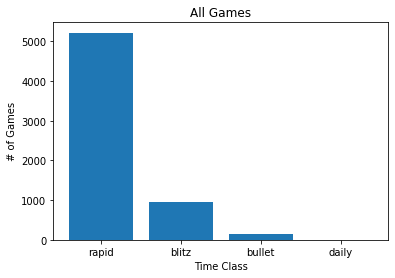

In [17]:
x = []
labels = []
for time_class in df['time_class'].unique():
    query_result = df.query(f"time_class == '{time_class}'")
    x.append(len(query_result))
    labels.append(time_class)

plt.bar(labels, x)
plt.xlabel('Time Class')
plt.ylabel('# of Games')
plt.title('All Games')
plt.show()

### How has my rating changed over time for each time class?

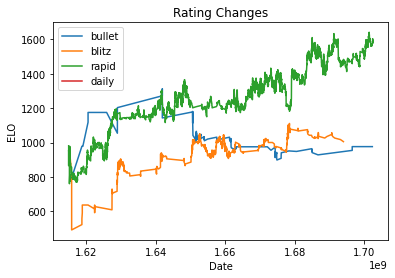

In [18]:
time_class_query = lambda time_class: f"time_class == '{time_class}'"
time_classes = {'chess_bullet': 'bullet', 'chess_blitz': 'blitz', 'chess_rapid': 'rapid', 'chess_daily': 'daily'}

for k, v in time_classes.items():
    games = df.query(time_class_query(v))
    games.head()
    games.sort_values('end_time_utx')
    ratings = []
    dates = []
    
    for idx, game in games.iterrows():
        rating = game['w_rating'] if game['w_username'] == username else game['b_rating']
        date = game['end_time_utx']
        ratings.append(rating)
        dates.append(date)
        
    plt.plot(dates, ratings, label=v)

    
plt.legend(loc="upper left")
plt.xlabel('Date')
plt.ylabel('ELO')
plt.title('Rating Changes')
plt.show()

### What is my success rate with my most popular openings

In [19]:
print(df['w_result'].unique())

['win' 'checkmated' 'resigned' 'abandoned' 'stalemate' 'agreed'
 'insufficient' 'timeout' 'repetition' '50move' 'timevsinsufficient']


In [20]:
win_conditions = ['win', 'checkmated']
draw_conditions = ['stalemate', 'agreed', 'insufficient', 'repetition', '50move', 'timevsinsufficient']
loss_conditions = ['resigned', 'abandoned', 'timeout']

In [21]:
white_wins = []
white_draws = []
white_losses = []
white_labels = []
white_totals = []
white_games = df.query(f"w_username == '{username}'")
for opening in white_games['opening'].unique():
    opening_games = white_games.query(f"opening == \"{opening}\"")
    white_wins.append(len(opening_games.query(f"w_result in {win_conditions}")))
    white_draws.append(len(opening_games.query(f"w_result in {draw_conditions}")))
    white_losses.append(len(opening_games.query(f"w_result in {loss_conditions}")))
    white_labels.append(opening)
    white_totals.append(len(opening_games))

w_zipped = sorted(zip(white_labels, white_totals, white_wins, white_draws, white_losses), key=lambda x: x[1], reverse=True)
w_zipped = w_zipped

In [22]:
x = [label[0] for label in w_zipped[:10]]
opening_wins = [label[2] for label in w_zipped[:10]]
opening_draws = [label[3] for label in w_zipped[:10]]
opening_losses = [label[4] for label in w_zipped[:10]]

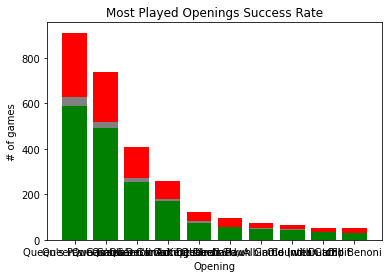

In [24]:
plt.bar(x, opening_wins, color='green')
plt.bar(x, opening_draws, bottom=opening_wins, color='gray')
plt.bar(x, opening_losses, bottom=np.add(opening_wins, opening_draws), color='red')
plt.xlabel('Opening')
plt.ylabel('# of games')
plt.title('Most Played White Openings Success Rate')
plt.show()

In [29]:
for opening in w_zipped[:10]:
    print(f"{opening[0]} -- {opening[2]} W / {opening[3]} D / {opening[4]} L ({round(opening[2] / opening[1] * 100)}% / {round(opening[3] / opening[1] * 100)}% / {round(opening[4] / opening[1] * 100)}%)")

Queen's Pawn Game -- 589 W / 37 D / 285 L (65% / 4% / 31%)
Queen's Gambit Declined -- 492 W / 27 D / 221 L (66% / 4% / 30%)
Queen's Gambit Accepted -- 256 W / 16 D / 138 L (62% / 4% / 34%)
Queen's Gambit Declined Slav -- 170 W / 8 D / 79 L (66% / 3% / 31%)
King's Indian -- 75 W / 6 D / 40 L (62% / 5% / 33%)
Queen's Gambit Declined, Albin Counter Gambit -- 57 W / 1 D / 37 L (60% / 1% / 39%)
Queen's Pawn Game (with ...d6) -- 48 W / 3 D / 25 L (63% / 4% / 33%)
Old Indian -- 42 W / 6 D / 19 L (63% / 9% / 28%)
Dutch -- 33 W / 2 D / 18 L (62% / 4% / 34%)
Old Benoni -- 29 W / 3 D / 20 L (56% / 6% / 38%)


In [30]:
black_wins = []
black_draws = []
black_losses = []
black_labels = []
black_totals = []
black_games = df.query(f"b_username == '{username}'")
for opening in black_games['opening'].unique():
    opening_games = black_games.query(f"opening == \"{opening}\"")
    black_wins.append(len(opening_games.query(f"b_result in {win_conditions}")))
    black_draws.append(len(opening_games.query(f"b_result in {draw_conditions}")))
    black_losses.append(len(opening_games.query(f"b_result in {loss_conditions}")))
    black_labels.append(opening)
    black_totals.append(len(opening_games))

b_zipped = sorted(zip(black_labels, black_totals, black_wins, black_draws, black_losses), key=lambda x: x[1], reverse=True)
b_zipped = b_zipped

In [31]:
x = [label[0] for label in b_zipped[:10]]
b_opening_wins = [label[2] for label in b_zipped[:10]]
b_opening_draws = [label[3] for label in b_zipped[:10]]
b_opening_losses = [label[4] for label in b_zipped[:10]]

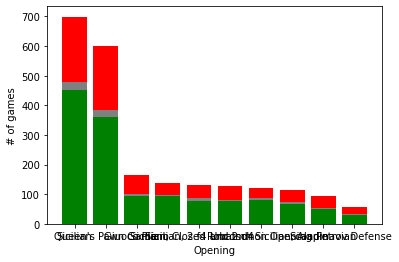

In [32]:
plt.bar(x, b_opening_wins, color='green')
plt.bar(x, b_opening_draws, bottom=b_opening_wins, color='gray')
plt.bar(x, b_opening_losses, bottom=np.add(b_opening_wins, b_opening_draws), color='red')
plt.xlabel('Opening')
plt.ylabel('# of games')
plt.show()

In [33]:
for opening in b_zipped[:10]:
    print(f"{opening[0]} -- {opening[2]} W / {opening[3]} D / {opening[4]} L ({round(opening[2] / opening[1] * 100)}% / {round(opening[3] / opening[1] * 100)}% / {round(opening[4] / opening[1] * 100)}%)")

Sicilian -- 452 W / 27 D / 220 L (65% / 4% / 31%)
Queen's Pawn Game -- 362 W / 22 D / 216 L (60% / 4% / 36%)
Giuoco Piano -- 94 W / 6 D / 64 L (57% / 4% / 39%)
Sicilian, Closed -- 93 W / 5 D / 39 L (68% / 4% / 28%)
Sicilian, 2.f4 and 2.d4 -- 77 W / 10 D / 43 L (59% / 8% / 33%)
Robatsch -- 78 W / 3 D / 47 L (61% / 2% / 37%)
Uncommon Opening -- 80 W / 7 D / 33 L (67% / 6% / 28%)
Sicilian, Alapin -- 68 W / 6 D / 41 L (59% / 5% / 36%)
Scandinavian -- 50 W / 2 D / 41 L (54% / 2% / 44%)
Petrov Defense -- 29 W / 5 D / 24 L (50% / 9% / 41%)


### What is my success rate on openings I have played less than 20 times? 

In [34]:
max_games = 20
total_wins = 0
total_games = 0
total_draws = 0
total_losses = 0
for opening in w_zipped + b_zipped:
    if opening[1] < max_games:
        total_games += opening[1]
        total_wins += opening[2]
        total_draws += opening[3]
        total_losses += opening[4]
        
print(f"Sum of uncommon openings (<{max_games} games):")
print(f"Total games: {total_games}")
print(f"{round(total_wins / (total_games) * 100, 2)}% Wins / {round(total_draws / total_games * 100, 2)}% Draws / {round(total_losses / total_games * 100, 2)}% Losses")

Sum of uncommon openings (<20 games):
Total games: 546
60.26% Wins / 3.48% Draws / 36.26% Losses


### How much time do I spend on average on each move?

In [44]:
# %H:%M:%S: -> seconds
def get_total_seconds(stringHMS):
   timedeltaObj = datetime.strptime(stringHMS, "%H:%M:%S") - datetime(1900,1,1)
   return timedeltaObj.total_seconds()

In [45]:
print(get_total_seconds(df.iloc[100]['moves'][1]['white']['clock']))

for game in 

600.0


In [ ]:
### How does my daily rating change on days I played a lot of games vs days i played few games?
### How correlated is my weekly rating 

In [ ]:
### Do i win more games when I castle in the first 10 moves?
### Does my opponenet lose more games if they have not castled by move 10

In [ ]:
# Track the number of puzzles done each day, and check correlation to games won.  I want to know if doing puzzles increases the changes of me winning games that day
